In [56]:
# Imports
import text_preprocessor
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import os
import re
import datetime as dt
from sklearn.naive_bayes import GaussianNB
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from joblib import dump
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix


In [36]:
txt_folder = os.getcwd() + '/10k_filings_clean/'
fin_folder = os.getcwd() + '/finance_data/'
processed_files = os.getcwd() + '/processed_files/'

In [37]:
# Open folder of html 10-k files
dir_list = os.listdir(txt_folder)

sent_data = pd.DataFrame({'Symbol':[]})

# Iterate through tickers in folder
for ticker in dir_list:
    # Pass each file into clean_html_text one at a time
    for file in os.listdir(txt_folder + '/' + ticker):
        input_path = txt_folder + '/' + ticker + '/' +  file
        ticker, date = file.split("_10-k_")
        date = date.replace(".txt","")
        d = {'Symbol':[ticker],'Date':[date],'Data':[text_preprocessor.process_text_files(input_path)]}
        new_df = pd.DataFrame(data=d)
        sent_data = pd.concat([sent_data, new_df], axis=0)



In [38]:
stock_data=pd.DataFrame()

pattern = re.compile(r'[A-Z]+')


for data in os.listdir(fin_folder):
    newdat=pd.DataFrame(pd.read_csv(fin_folder + '/' + data))
    newdat.loc[:,'Symbol']=pd.Series([next(pattern.finditer(data))[0] for i in range(0,newdat.shape[0])])
    stock_data=pd.concat([stock_data,newdat],axis=0)
    
# stock_data['Date'] = pd.to_datetime(stock_data['Date'])

def direction(x):
    if x>0:
        return 1
    else:
        return 0


C:\Users\KIRSTY~1\AppData\Local\Temp/ipykernel_19704/193429313.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  newdat.loc[:,'Symbol']=pd.Series([next(pattern.finditer(data))[0] for i in range(0,newdat.shape[0])])


In [39]:
stock_data['Direction'] = stock_data['1daily_return'].apply(direction)
stock_data = stock_data[['Symbol','Date','Direction']]


In [40]:

# Compiling the data
df_total=pd.merge(sent_data,stock_data,how='inner', left_on=['Symbol','Date'],right_on=['Symbol','Date'])
# df_total.drop(columns='Unnamed: 0', inplace=True)

In [82]:

# Create a Gaussian Naive Bayes Classifier
#vectorizer = TfidfVectorizer()
vectorizer = CountVectorizer(ngram_range = (1,1))
model = MultinomialNB()

# Create the data
df_train, df_test = train_test_split(df_total,test_size=0.2)
X_train = vectorizer.fit_transform(df_train['Data'])
y_train = df_train['Direction']

X_test = vectorizer.transform(df_test['Data'])
y_test = df_test['Direction']

# Fit the model
model.fit(X_train,y_train)

# Save the model to file 
dump(vectorizer, './Tfidfvectorizer.joblib')
dump(model, './model.joblib')


['./model.joblib']

In [83]:
test_predictions = model.predict(X_test)
train_predictions = model.predict(X_train)

test_acc = accuracy_score(y_test,test_predictions)
train_acc = accuracy_score(y_train,train_predictions)
print(test_acc)
print(train_acc)

0.5371900826446281
0.75


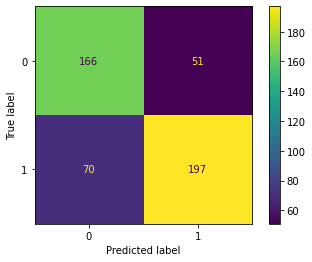

In [85]:
cm = confusion_matrix(df_train['Direction'],train_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()


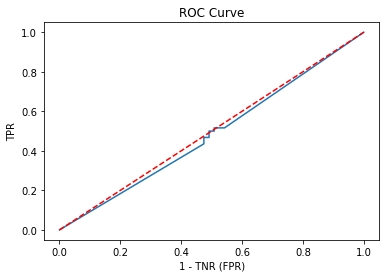

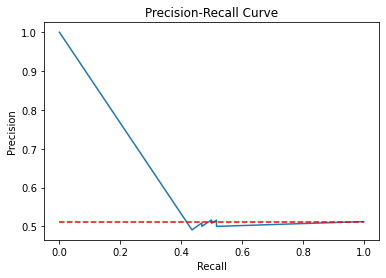

In [61]:
predictions = model.predict_proba(X_test)[:,1]
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay
fpr, tpr, threshold = roc_curve(df_test['Direction'], predictions)
roc_auc_score(df_test['Direction'], predictions)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_xlabel('1 - TNR (FPR)')
ax.set_ylabel('TPR')
ax.set_title('ROC Curve')
ax.plot([0,1],[0,1],color='red',linestyle='--')

precision, recall, threshold = precision_recall_curve(df_test['Direction'], predictions)
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
no_skill = len(df_test[df_test['Direction']==1]) / len(df_test)
ax.plot([0,1],[no_skill,no_skill],color='red',linestyle='--')